# CVAE Notebook

### Implements the training, testing and evaluation scripts for the CVAE architecture in a segemented organised manner.

## 1. Importing Relevant Modules


In [2]:
import numpy as np
import torch
import torch.optim 
from torch.utils.data import DataLoader, TensorDataset
import glob

import os
from tqdm import tqdm
import random
import time
import torch
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import json
from matplotlib.ticker import AutoMinorLocator

import data_utils as du
import cvae_tools as nt
import model_eval as me

import importlib

importlib.reload(me)
importlib.reload(nt)
importlib.reload(du)

DEVICE = torch.device("mps")

s = 42

torch.use_deterministic_algorithms(True)
torch.backends.mps.deterministic = True
torch.backends.mps.benchmark = False

np.random.seed(s)
torch.manual_seed(s)
torch.mps.manual_seed(s)
random.seed(s)

os.chdir('/Users/Mak/Desktop/Imperial College London/Year Four/MSci Project/Codebase/')

## 2. Setting Variables

* `normal_path`: The Directory to stores min-max normalised data and model outputs.

* `raw_path`: The directory storing csvs and json files from the MC Simulation Software.

    * CSV: Event-wise observables data - in the order: q2, cos_theta_l, cos_theta_d, phi

    * JSON: The input wilson coefficients for the simulation software.

* `number_bins`: The number of bins in each dimension of the simulation data

* `train_amt`: How many of the MC dataset to used to train the model. This is usually ~70-80% of the dataset.

In [3]:
normal_path = 'nn_outputs/wilson_tau_csr_cvr_KLD'

raw_path = 'raw_data/dstore_tau_csr_cvr'

number_bins = 10

number_of_files = len(glob.glob(raw_path + '/*.csv'))

train_amount = int(0.6 * number_of_files)
val_amount = int(0.2 * number_of_files)

## 3. Normalising Variables

* Use set variables min-max normalise observables and construct 4d histograms. Then min-max normalise the bin-heights as well.

* Only needs to be run once per dataset.

In [3]:
du.file_to_normalise_4d(raw_path, normal_path, number_bins, bkg=False) 

Processing File No. model_WET_tau_633: 100%|██████████| 1792/1792 [05:06<00:00,  5.84it/s] 


## 4. Load in Data:

1. Min-max normalise the bin-heights of the whole dataset

2. Load in min-max normalised data, store them in appropriate variables and create dataloaders for model pass through.


In [4]:
train_inputs, train_targets, val_test_inputs, val_test_targets, file_names = du.load_minmax_heights(normal_path, train_amount)

# =-=-=-= Splitting the remaining data into validation and testing datasets =-=-=-=
val_inputs, val_targets = val_test_inputs[:val_amount], val_test_targets[:val_amount]

test_inputs, test_targets = val_test_inputs[val_amount:], val_test_targets[val_amount:]

# =-=-=-= Load in the Bayesian Optimised Hyperparmaeters into a Dictionary =-=-=-=
cfg = nt.BO_CVAE(normal_path[:-4], train_inputs, train_targets)

CSV Files: Bin Heights Already Normalised.


## 4(a). Create Data-Loaders with the above data, Ready for Model Passthrough

In [5]:
# =-=-= DataLoader Initialisation =-=-=
load_train = DataLoader(TensorDataset(train_inputs, train_targets), batch_size=cfg['batch_train'], shuffle=True, num_workers=0)

load_val = DataLoader(TensorDataset(val_inputs, val_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

load_test = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=cfg['batch_test'], shuffle=False, num_workers=0)

# =-=-= DataLoader Used for Model Output Storage Only =-=-=
load_vis = DataLoader(TensorDataset(test_inputs, test_targets), batch_size=1, shuffle=False, num_workers=0)

## 5. Training the Model:

1. Initialise loss function, Optimised-Model, and Optimiser.

2. Initialise variables to store loss evolution and Early Stopping parameters.
    - Loss evolution plotted later as a sanity check.

    - Early Stopping: adjust only `early_stopping_patience` (integer) to adjust how strict training should be.

3. Run the training loop - `train_epoch_early_CVAE` in the `CVAE_tools.py` notebook takes in:
    - Model, Training dataloader, Validation dataloader, Loss Function, Optimiser, and operating DEVICE (GPU or CPU)

    - This function takes care of all the loss calculation, backpropagation and optimiser steps.

    - Returns Losses, which are stored and compared for early stopping.

4. Store the Trained Model - Adjust the filename however you want - Variable: `save_path`

In [6]:
def loss_function_KLD(reconstruction, x, mean, logvar, beta=0.1, target_std=0.7):
    # Reconstruction loss (mean squared error)
    MSE = torch.nn.functional.mse_loss(reconstruction, x, reduction='sum')
    
    # Adjust logvar for the target standard deviation
    target_logvar = torch.log(torch.tensor(target_std ** 2).to(DEVICE))
    
    # Kullback-Leibler Divergence for a normal distribution with specified mean and standard deviations
    KLD = -0.5 * torch.sum(1 + (logvar - target_logvar) 
                                 - (logvar.exp() / target_std ** 2))
    
    loss = MSE + beta * KLD
    
    return loss

In [110]:
# =-=-=-= 1. Define the Loss Function and Model using Bayesian Optimised Hyperparameters =-=-=-=
loss_func = loss_function_KLD
base = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'],
                    encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                   dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

base.to(DEVICE)

# =-=-=-= 1. Optimiser specified =-=-=-=
optimiser = torch.optim.AdamW(base.parameters(), lr=1e-3, weight_decay=1e-4)

# 2. Variables to store losses plotted out later
loss_evol = []
val_loss_evol = []

# 2. Early Stopping Conditions - adjust only the patience value based on How constrained you want it.
early_stopping_patience = 10
best_val_loss = np.inf
epochs_without_improvement = 0

# 3. Training loops
for epoch in (pbar := tqdm(range(cfg['epochs']))):
    avg_loss, avg_val_loss = nt.train_epoch_early_CVAE(base, load_train, load_val, loss_func, optimiser, DEVICE)
    pbar.set_description(f"Training Epoch: {epoch + 1}/{cfg['epochs']}, Avg. Training Loss: {avg_loss:.5f}, Avg. Validation Loss: {avg_val_loss:.5f}")

    loss_evol.append(avg_loss)
    val_loss_evol.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0

    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

# =-=-=-= 4. Change normal path where appropriate =-=-=-=-=
save_path = normal_path + '/CVAE_tau_4d.pth'
torch.save(base.state_dict(), save_path)

# plt.plot(list(range(cfg['epochs'])), loss_evol)

Training Epoch: 86/150, Avg. Training Loss: 707.16432, Avg. Validation Loss: 88.35779:  57%|█████▋    | 85/150 [00:47<00:36,  1.79it/s]  

Early stopping triggered after 86 epochs.


## 5(a). Training-Validation Loss Evolution Plot

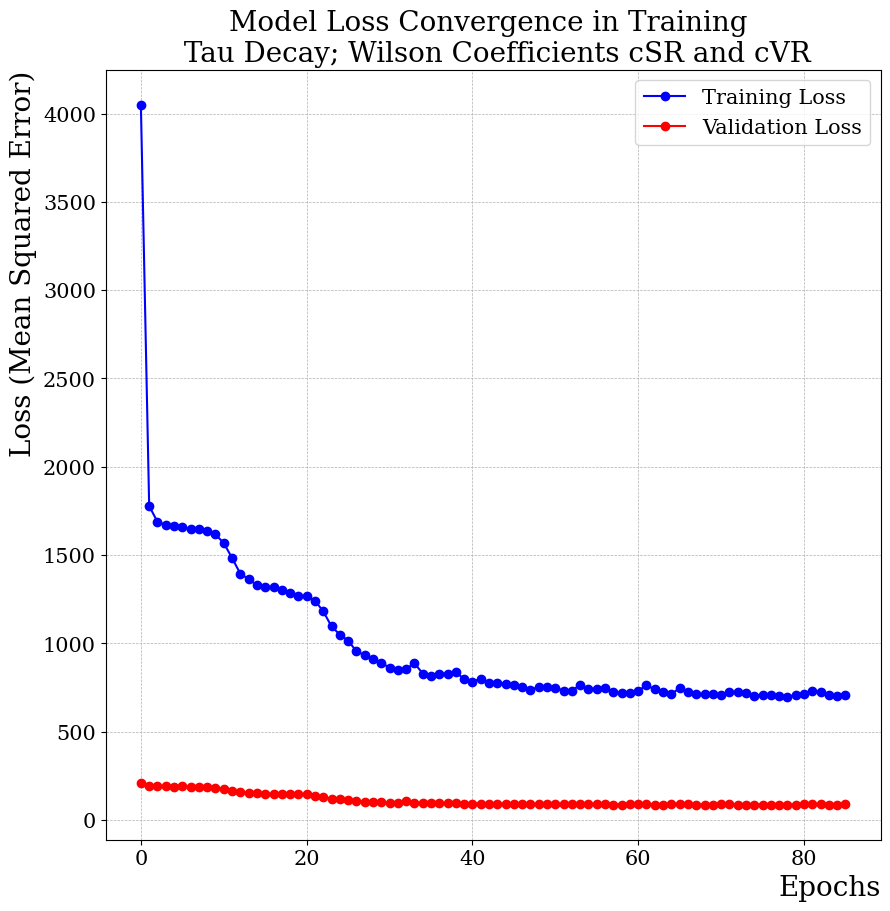

In [111]:
plt.figure(figsize=(10, 10))
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 15
plt.plot(list(range(cfg['epochs']))[:len(loss_evol)], loss_evol, 'o-', color='blue', label='Training Loss')
plt.plot(list(range(cfg['epochs']))[:len(loss_evol)], val_loss_evol, 'o-', color='red', label='Validation Loss')

plt.xlabel('Epochs', fontsize=20, loc='right')
plt.ylabel('Loss (Mean Squared Error)', fontsize=20, loc='top')
plt.title('Model Loss Convergence in Training \n Tau Decay; Wilson Coefficients cSR and cVR', fontsize=20)
# plt.yscale('log')

plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.5)

plt.legend()

## 6. Testing the Model

1. Initialising loss function, retrieving the trained model and loading it in.

2. Run the testing function - evaluates the whole testing set and returns losses
    - Good performance here should give values similar to the training loss

3. Goes 1 by 1 - Using visualisation dataset to extract model outputs for each dataset 
    - Visualise Each dataset compared to EOS and directly verify performance..

In [112]:
# =-=-= 1. Initialising of Testing Variables =-=-=
best_model = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                         encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                         dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

# =-=-= 1. Load best model data =-=-=
best_model.load_state_dict(torch.load(save_path, weights_only = False))
best_model.to(DEVICE)

# =-=-= 2. Run the testing epoch - Operates like the training epoch without gradient calculation =-=-=
out = nt.test_epoch_CVAE(best_model, load_test, loss_function_KLD, DEVICE)
print('Average Loss of Test Set', out)

# =-=-= 3. Store the model's outputs for the testing dataset =-=-=
store_test = nt.test_visualise_4d_CVAE(best_model, load_vis, DEVICE, train_amount + val_amount, normal_path, number_bins, file_names)

Average Loss of Test Set 89.22156422932943


359it [00:11, 32.61it/s]


## 6(a). Plot out Integrated Histogram of One Variable

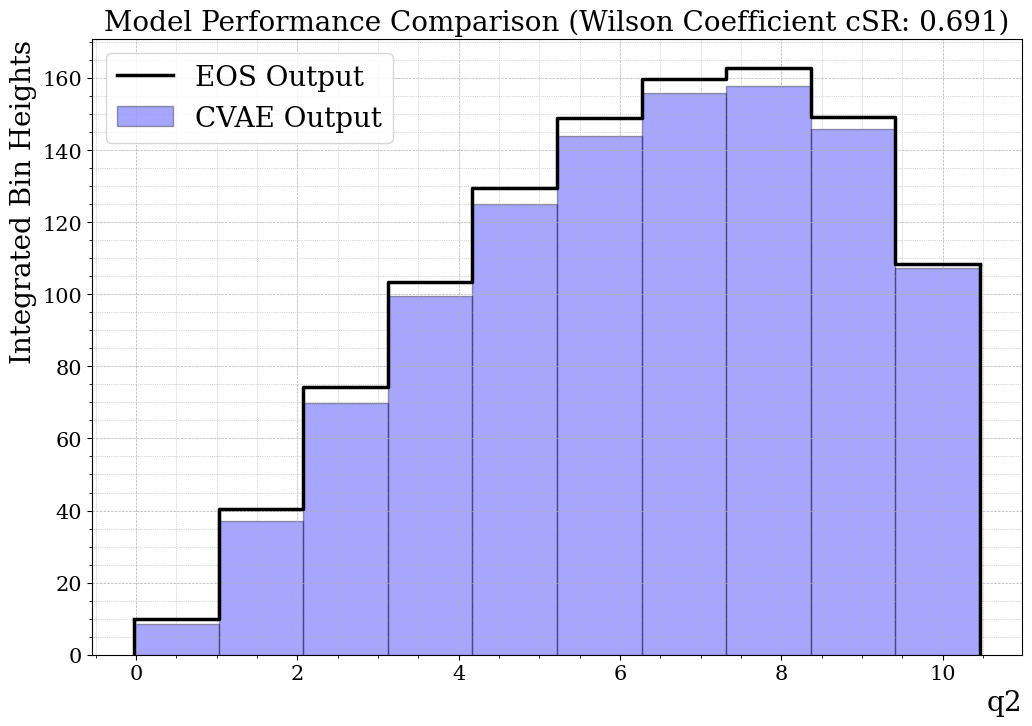

In [16]:
# File number must exist in the model_outputs directory
me.plot_1d_stk_tau(data_path="nn_outputs/wilson_tau_csr_cvr_KLD", x_var='q2', filenumber=142)

## 7. Performance Evaluations

**Finds Memory used, run-time, number of parameters, etc.**

In [69]:
def count_parameters(state_dict):
    total_params = 0
    for param_tensor in state_dict:
        total_params += state_dict[param_tensor].numel()
    return total_params

# Load the state dictionary from the .pth file
state_dict = torch.load(normal_path + '/CVAE_tau_4d.pth', weights_only=False)

# Count the number of parameters
total_params = count_parameters(state_dict)

print(f'Total number of parameters: {total_params}')

Total number of parameters: 9871410


In [7]:
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil

fixed_inputs = torch.Tensor([0.75, 0.75]).to(DEVICE)

csr_model_gen = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                            encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                            dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

csr_model_gen.load_state_dict(torch.load('nn_outputs/wilson_tau_csr_cvr_KLD/CVAE_tau_4d.pth', weights_only=False))
csr_model_gen.to(DEVICE)

model_heights_list = []
int_heights_list = []

time_list = []
memory_usage_list = []

nbins=10

bin_edges = np.linspace(0, 1, nbins + 1)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2

process = psutil.Process()

for i in range(50):
    with torch.no_grad():
        start_time = time.time()

        # Measure memory usage before model generation
        mem_before = process.memory_info().rss

        sample = csr_model_gen.generate_histogram(fixed_inputs)

        outputs = sample.to('cpu')
        reshaped_outputs = np.array(outputs.reshape(nbins, nbins, nbins, nbins))

        xpos, ypos, zpos, wpos = np.meshgrid(bins, bins, bins, bins, indexing="ij")

        result_df = pd.DataFrame({
                'q2': xpos.ravel(),
                'cos_theta_l': ypos.ravel(),
                'cos_theta_d': zpos.ravel(),
                'phi': wpos.ravel(),
                'bin_height': reshaped_outputs.ravel()
            })
        
        df_integrated = result_df.groupby(['cos_theta_d'])["bin_height"].sum().reset_index()

        x_unq = np.unique(result_df['cos_theta_d'].values)
        x_unq = (x_unq * 10.48) - 0.02

        # Measure memory usage after model generation
        mem_after = process.memory_info().rss

        end_time = time.time()
        sample = sample.cpu().numpy()

        # Calculate memory usage for the model generation
        mem_usage = mem_after - mem_before
        memory_usage_list.append(mem_usage)

        delta = end_time - start_time

        time_list.append(delta)
        model_heights_list.append(result_df['bin_height'].values)
        int_heights_list.append(df_integrated['bin_height'].values)

# Print memory usage statistics
print(f"Average memory usage per iteration: {np.mean(memory_usage_list) / (1024 ** 2):.2f} MB")
print(f"Maximum memory usage in an iteration: {np.max(memory_usage_list) / (1024 ** 2):.2f} MB")
print(f"Minimum memory usage in an iteration: {np.min(memory_usage_list) / (1024 ** 2):.2f} MB")

Average memory usage per iteration: 0.35 MB
Maximum memory usage in an iteration: 17.42 MB
Minimum memory usage in an iteration: 0.00 MB


## 8. Rough Work - Random Tests of Specific Functionality

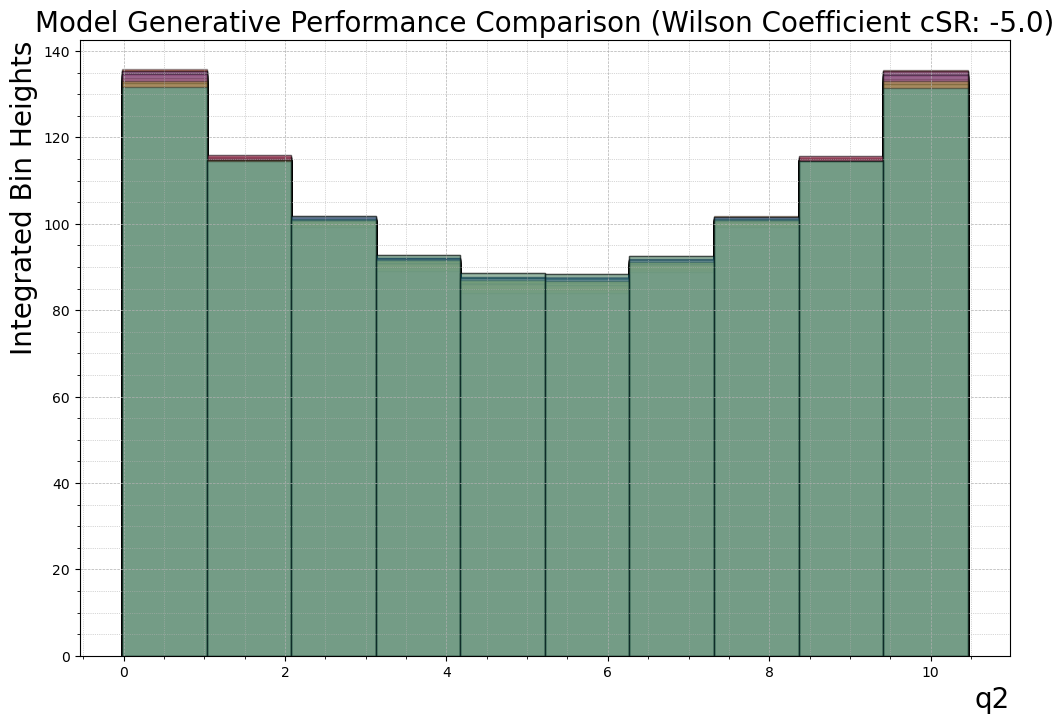

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
w = np.diff(x_unq)[-1]

for h in int_heights_list:
    # Plot the NN dataset
    ax.bar(x_unq, h, width=w, edgecolor='black', alpha=0.35, label='CVAE Output')

    # Add labels and title
    ax.set_xlabel('q2', fontsize=20, loc='right')
    ax.set_ylabel('Integrated Bin Heights', fontsize=20, loc='top')
    ax.set_title(f'Model Generative Performance Comparison (Wilson Coefficient cSR: -5.0)', fontsize=20)

    # Add minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle=':', linewidth=0.5)

plt.show()


In [9]:
model_heights_list = np.array(model_heights_list)

stds = []

for i in range(len(model_heights_list[0])):
    column = model_heights_list[:, i]
    stds.append(column.std())

print('Standard Deviations of Columns:', np.mean(stds))

Standard Deviations of Columns: 0.00293104


In [10]:
eos_heights_list = []
int_eos_heights = []

fp = os.listdir('nn_outputs/wilson_csr_fit/normal_inputs')

for fil in fp:

    f = os.path.join('nn_outputs/wilson_csr_fit/normal_inputs', fil)

    with open(f, 'r') as file:
        wilson = json.load(file)
    
    if wilson['wc_0'] == 0.75:
        base_name = os.path.basename(f)
        
        data_name = base_name.replace('.json', '.csv')

        data_path = os.path.join('nn_outputs/wilson_csr_fit/normal_targets', data_name)

        df = pd.read_csv(data_path)
        df_integrated = df.groupby(['cos_theta_l'])["bin_height"].sum().reset_index()

        x_unq = np.unique(df['q2'].values)
        x_unq = (x_unq * 10.48) - 0.02

        int_eos_heights.append(df_integrated['bin_height'].values)
        eos_heights_list.append(df['bin_height'].values)
    
    else:
        continue

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
w = np.diff(x_unq)[-1]

for h in int_eos_heights:
    # Plot the NN dataset
    ax.bar(x_unq, h, width=w, edgecolor='black', alpha=0.35, label='CVAE Output')

    # Add labels and title
    ax.set_xlabel('q2', fontsize=20, loc='right')
    ax.set_ylabel('Integrated Bin Heights', fontsize=20, loc='top')
    ax.set_title(f'EOS Generative Performance Comparison (Wilson Coefficient cSR: -5.0)', fontsize=20)

    # Add minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle=':', linewidth=0.5)

plt.show()

In [12]:
eos_heights_list = np.array(eos_heights_list)

eos_stds = []

for i in range(len(eos_heights_list[0])):
    column = eos_heights_list[:, i]
    eos_stds.append(column.std())

print('Standard Deviations of Columns:', np.mean(eos_stds))

Standard Deviations of Columns: 0.03821686066041479


In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
w = np.diff(x_unq)[-1]

for h in eos_heights_list:
    # Plot the NN dataset
    ax.bar(x_unq, h, width=w, edgecolor='black', alpha=0.35, label='CVAE Output')

    # Add labels and title
    ax.set_xlabel('q2', fontsize=20, loc='right')
    ax.set_ylabel('Integrated Bin Heights', fontsize=20, loc='top')
    ax.set_title(f'Model Generative Performance Comparison (Wilson Coefficient cSR: -5.0)', fontsize=20)

    # Add minor ticks
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.grid(which='minor', linestyle=':', linewidth=0.5)


plt.show()

In [ ]:
CVAE = nt.CVAE_Opt(input_shape=cfg['dim'][0], output_shape=cfg['dim'][1], latent_dim=cfg['latent_dim'], 
                   encoder_layers=cfg['encoder'], decoder_layers=cfg['decoder'],
                   dropout_enc=cfg['encoder_drop'], dropout_dec=cfg['decoder_drop'])

CVAE.load_state_dict(torch.load('nn_outputs/wilson_tau_csr_cvr_KLD/CVAE_tau_4d.pth', weights_only=False))

num_points = 20  # You can adjust this value as needed
x = np.linspace(0, 1, num_points, endpoint=False)
y = np.linspace(0, 1, num_points, endpoint=False)
xx, yy = np.meshgrid(x, y)
meshgrid_array = np.vstack([xx.ravel(), yy.ravel()]).T

meshgrid_tensor = torch.tensor(meshgrid_array, dtype=torch.float32)

mean, logvar = CVAE.encoder(meshgrid_tensor)

print('Log-Variations:', logvar)
print('Means:', mean)

In [30]:
logvar.exp()

tensor([[0.0089, 0.0085, 0.0095,  ..., 0.0095, 0.0106, 0.0091],
        [0.0089, 0.0086, 0.0094,  ..., 0.0095, 0.0104, 0.0091],
        [0.0088, 0.0087, 0.0093,  ..., 0.0094, 0.0103, 0.0092],
        ...,
        [0.0080, 0.0083, 0.0083,  ..., 0.0088, 0.0086, 0.0080],
        [0.0076, 0.0080, 0.0080,  ..., 0.0086, 0.0085, 0.0078],
        [0.0072, 0.0077, 0.0077,  ..., 0.0084, 0.0084, 0.0075]],
       grad_fn=<ExpBackward0>)